In [1]:
# Install liblinear: sudo apt-get install python-liblinear
# from liblinearutil import *
import numpy as np
from sklearn import preprocessing

In [22]:
def do_normalize(x):
    x = np.array(x)
    x_scaled = preprocessing.scale(x)
    return x_scaled

def read_problem(file_name,feature_len):
    y = []
    x = []
#     feature_len = 22
    ct = 0
    for line in open(file_name):
        ct += 1
        tmp = line.split(' ',1)
        y = y + [int(float(tmp[0]))]
        vec = np.zeros(feature_len)
        for each in tmp[1].split():
            index,val = each.split(':')
            vec[int(index)-1] = float(val)
        x.append(vec)
    x = do_normalize(x)
    x = np.array(x)
    y = np.array(y)
    return y,x

def convert_to_dictionary(x):
    feature_len = x.shape[1]
    indx = range(1,feature_len+1)
    x_new = []
    for row in x:
        x_new.append(dict(zip(indx,row)))
    return x_new

# Gradient ascent step for dual variables

In [44]:
def get_tp_tn(x,y,w):
    h = x.dot(w)
    ind = np.where(h>0)
    y1 = -1*np.ones_like(y)
    y1[ind] = 1
    tp = sum(np.multiply(1+y,1+y1)/4)
    tn = sum(np.multiply(1-y,1-y1)/4)
    return tp,tn

def get_projection(alpha,beta):
    if alpha>0 and beta>0 and alpha*beta>=1.0/4:
        return alpha,beta
    coef = [16,-16*alpha,0,4*beta,-1]
    roots = np.roots(coef)
    im = np.imag(roots)
    re = np.real(roots)
    for r,i in zip(re,im):
        if i==0 and r>0:
            r1 = 1.0/(4*r)
            return np.round(r,decimals=2),np.round(r1,decimals=2)
        
def cross_validation_objective(x,y,w,a,b):
    n = len(y)
    ind_pos = [i for i in range(n) if y[i]>0]
    ind_neg = [i for i in range(n) if y[i]<0]
    x_pos = x[ind_pos]
    x_neg = x[ind_neg]
    n_pos = len(ind_pos)
    n_neg = len(ind_neg)
    # positives
    tmp = np.maximum(0,1 - (2*n_pos)/(a*n)*x_pos.dot(w))
    obj = a/n_pos*sum(tmp)
    # negatives
    tmp = np.maximum(0,1 + (2*n_neg)/(b*n)*x_neg.dot(w))
    obj += b/n_neg*sum(tmp)
    obj = obj-(a+b)
    return obj

# Change it to gradient descent
def gradient_ascent(x,y,x_val,y_val,w,a,b,alpha=1,maxiter=25,tolerance=0.0001):
    global accuracy
    n = x.shape[0]
    n_pos = len([i for i in range(n) if y[i]==1])
    n_neg = n-n_pos
    ind_pos = [i for i in range(n) if y[i]>0]
    ind_neg = [i for i in range(n) if y[i]<0]
    x_pos = x[ind_pos]
    x_neg = x[ind_neg]
    tpr,tnr = get_tp_tn(x,y,w)
    tpr /= float(n_pos)
    tnr /= float(n_neg)
    accuracy.append((tpr,tnr))
    print('-------------Starting Gradient Ascent: step={},tolerance={}------------'.format(alpha,tolerance))
    print('n_pos={},n_neg={},TPR ={},TNR={}'.format(n_pos,n_neg,tpr,tnr))
    for it in range(maxiter):
#         alpha = 1.0/(it+1)
        # for positives
        tmp = 1 - (2*n_pos)/(a*n)*x_pos.dot(w)
        j = np.where(tmp>1)[0] # misclassification instead of margin violation
        tmp = np.zeros_like(tmp)
        tmp[j]=1.0
        pos_violation = sum(tmp)
#         print('pos-violation={}'.format(sum(tmp)))
        ga = sum(tmp)/n_pos-1
        # for negatives
        tmp = 1 + (2*n_neg)/(b*n)*x_neg.dot(w)
        j = np.where(tmp>1)[0] # misclassification instead of margin violation
        tmp = np.zeros_like(tmp)
        tmp[j]=1.0
        neg_violation = sum(tmp)
#         print('neg-violation={}'.format(sum(tmp)))
        gb = sum(tmp)/n_neg-1
        # Update a,b
        if np.sqrt(ga*ga+gb*gb)<tolerance:
            print('------------Returning[gradient too small]: grad_pos = {} grad_neg = {}-----------'.format(ga,gb))
            return a,b
        a += alpha*ga
        b += alpha*gb
        # Projection to a,b \in R+ \intersect ab>1/4
        a,b = get_projection(a,b)
        cv_obj = cross_validation_objective(x_val,y_val,w,a,b)
        if it>0 and cv_obj-cv_obj_prev<=0:
            alpha /= 10.0
        print('#{} grad_pos={}, grad_neg={}, objective={}, stepsize={}'.format(it,ga,gb,cv_obj,alpha))
        cv_obj_prev = cv_obj
    print('---------------Returning[normal]: grad_pos = {} grad_neg = {}-------------'.format(ga,gb))
    return a,b

## Liblinear for primal variable w

In [4]:
# customized liblinear
import sys
sys.path.insert(0, "/home/debojyoti/opt/liblinear-2.1")
from ppython import liblinear
from ppython.liblinear import *
from ppython.liblinearutil import *

In [30]:
y_cov,x_cov = read_problem('./data/covtype.libsvm.binary',54)

In [31]:
x,y = x_cov,y_cov
y[np.where(y==2)]=-1
n_total = len(y)
n_train = int(n_total * 0.8)
rand_ind = np.random.permutation(n_total)
train_ind = rand_ind[:n_train]
test_ind = rand_ind[n_train:]
x_train,y_train = x[train_ind],y[train_ind]
x_test,y_test = x[test_ind],y[test_ind]

In [ ]:
def modifyx(x,y,a,b,n,n_pos,n_neg):
    scale_pos = float(2*n_pos)/(a*n)
    scale_neg = float(2*n_neg)/(b*n)
    for i in range(len(y)):
        if y[i]==1:
            x[i].update((key,val*scale_pos) for key,val in x[i].items())
        else:
            x[i].update((key,val*scale_neg) for key,val in x[i].items())
    return x
# init section
a,b = 0.5,0.5

# IJCNN dataset
y_train,x_train = read_problem('./data/ijcnn1.tr',22) # x as numpy list
y_val,x_val = read_problem('./data/ijcnn1.val',22)

# # Covtype dataset
# %time y,x = read_problem('./data/covtype.libsvm.binary',54)
# y[np.where(y==2)]=-1
# n_total = len(y)
# n_train = int(n_total * 0.8)
# rand_ind = np.random.permutation(n_total)
# train_ind = rand_ind[:n_train]
# test_ind = rand_ind[n_train:]
# x_train,y_train = x[train_ind],y[train_ind]
# x_val,y_val = x[test_ind],y[test_ind]

n_dim = len(x_train[0])
w = np.random.uniform(low=-1,high=1,size=(n_dim,))
# y_train_svm,x_train_svm = svm_read_problem('./data/ijcnn1.tr') # x in liblinear compatible dictionary format
x_train_svm = convert_to_dictionary(x_train)
y_train_svm = y_train
n = len(y_train)
n_pos = len([i for i in range(n) if y_train[i]==1])
n_neg = n-n_pos
c = 5
accuracy = []
# Iterative section: Gradient Ascent & Liblinear
for i in range(20):
    a,b = gradient_ascent(x_train,y_train,x_val,y_val,w,a,b) #Gradient ascent
    c1 = float(a)/n_pos
    c2 = float(b)/n_neg
    param = parameter('-s 3 -w1 {} -w-1 {} -c {}'.format(c1,c2,c))
    x = modifyx(x_train_svm,y_train_svm,a,b,n,n_pos,n_neg)
    prob = problem(y_train_svm,x)
    print('--------------------Running SVM, a = {}, b = {}----------------------'.format(a,b))
    model = train(prob,param)
    # Get model parameters
    w = model.get_decfun()[0]

-------------Starting Gradient Ascent: step=1,tolerance=0.0001------------
n_pos=3415,n_neg=31585,TPR =0.5610541727672035,TNR=0.5533006173816685
#0 grad_pos=-0.5610541727672036, grad_neg=-0.5533006173816686, objective=1.5256297126642964, stepsize=1
#1 grad_pos=-0.5610541727672036, grad_neg=-0.5533006173816686, objective=1.5256297126642964, stepsize=0.1
#2 grad_pos=-0.5610541727672036, grad_neg=-0.5533006173816686, objective=1.5256297126642964, stepsize=0.01
#3 grad_pos=-0.5610541727672036, grad_neg=-0.5533006173816686, objective=1.5256297126642964, stepsize=0.001
#4 grad_pos=-0.5610541727672036, grad_neg=-0.5533006173816686, objective=1.5256297126642964, stepsize=0.0001
#5 grad_pos=-0.5610541727672036, grad_neg=-0.5533006173816686, objective=1.5256297126642964, stepsize=1e-05
#6 grad_pos=-0.5610541727672036, grad_neg=-0.5533006173816686, objective=1.5256297126642964, stepsize=1.0000000000000002e-06
#7 grad_pos=-0.5610541727672036, grad_neg=-0.5533006173816686, objective=1.5256297126642

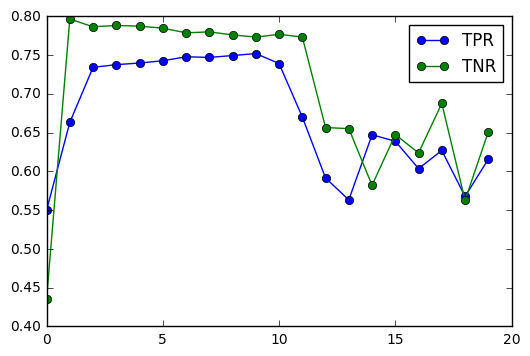

In [54]:
import matplotlib.pyplot as plt
%matplotlib inline
p = [x for x,_ in accuracy]
n = [x for _,x in accuracy]
tpr, = plt.plot(range(len(p)),p,marker='o',label='TPR')
tnr, = plt.plot(range(len(n)),n,marker='o',label='TNR')
plt.legend(handles=[tpr,tnr])

[ 0.48908223  0.72694271  0.76004031  0.76265264  0.76332215  0.7635582
  0.76326652  0.76341888  0.76275452  0.76263697  0.75787726  0.71997566
  0.62323299  0.60754507  0.61384069  0.64324883  0.61370013  0.65669026
  0.56522251  0.63322972]


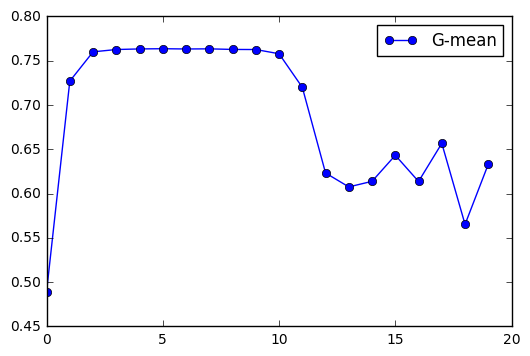

In [55]:
import matplotlib.pyplot as plt
%matplotlib inline
p = [x for x,_ in accuracy]
n = [x for _,x in accuracy]
g = np.sqrt(np.multiply(p,n))
print(g)
gmean, = plt.plot(range(len(g)),g,marker='o',label='G-mean')
plt.legend(handles=[gmean])

In [15]:
x = [1,2,3]
y = [1,2,3]
np.sqrt(np.multiply(x,y))

array([ 1.,  2.,  3.])